In [1]:
import pandas as pd
import numpy as np
import seaborn as sea
import datetime as dt
from datetime import timedelta
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

In [2]:
coronga = pd.read_csv(url, error_bad_lines=False)

In [3]:
coronga.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
coronga = coronga.fillna({'continent':"No Continent",'total_cases':0, 'new_cases':0,
       'total_deaths':0, 'new_deaths':0, 'population':0, 'population_density':0,
       'median_age':0,'new_tests':0,'median_age':50,'life_expectancy':0,'positive_rate':0})

#Criação de Colunas novas em relação à datas
coronga['date'] = pd.to_datetime(coronga['date'])
coronga['day'] = coronga['date'].dt.day
coronga['month'] = coronga['date'].dt.month
coronga['year'] = coronga['date'].dt.year


#Trimestre,Semestre,bimestre
coronga['quarter'] = coronga['date'].dt.quarter
coronga['half'] = np.where(coronga['month']>6, 2, 1)
#Condições
cond = [
    (coronga['month'] <= 2),
    (coronga['month'] > 2) & (coronga['month'] <= 4),
    (coronga['month'] > 4) & (coronga['month'] <= 6),
    (coronga['month'] > 6) & (coronga['month'] <= 8),
    (coronga['month'] > 8) & (coronga['month'] <= 10),
    (coronga['month'] > 10)
    ]

# Lista de valores para cada condição
vl = [1,2,3,4,5,6]

# Nova coluna baseada nos valores anteriores
coronga['bimonth'] = np.select(cond, vl)

coronga.loc[coronga['month'] < 10, 'month'] = '0' + coronga['month'].map(str)
coronga.loc[coronga['day'] < 10, 'day'] = '0' + coronga['day'].map(str)
coronga['date_id'] = coronga['year'].map(str) + coronga['month'].map(str) + coronga['day'].map(str)


#Criando Codigos para as Categoricas
coronga['continent'] = coronga['continent'].astype('category')
# Criando os codigos de Continente
coronga['cod_continent'] = coronga['continent'].cat.codes
coronga['location'] = coronga['location'].astype('category')
# Criando os codigos de Local
coronga['cod_location'] = coronga['location'].cat.codes

#exportar Tabelas relacionadas.
local = coronga['location']
continentes = coronga['continent']
cd_local = coronga['cod_location']
cd_continentes = coronga['cod_continent']
cd_date = coronga['date_id']
date = coronga['date']
data_local = {'cod':cd_local.unique(),
              'location':local.unique()}
data_continent = {'cod':cd_continentes.unique(),
              'continent':continentes.unique()}
data_date = {'sk_date':cd_date.unique(),
             'date':date.unique()}
df_local = pd.DataFrame(data_local)
df_continent = pd.DataFrame(data_continent)
df_date = pd.DataFrame(data_date)

last_dt = pd.to_datetime(df_date['date'].iloc[-1])
for x in range(0,10):
    new_row = {'date':last_dt + timedelta(x+1)}
    df_date = df_date.append(new_row, ignore_index=True)
    
df_date['day'] = df_date['date'].dt.day
df_date['month'] = df_date['date'].dt.month
df_date['year'] = df_date['date'].dt.year
df_date.loc[df_date['month'] < 10, 'month'] = '0' + df_date['month'].map(str)
df_date.loc[df_date['day'] < 10, 'day'] = '0' + df_date['day'].map(str)
df_date['date_id'] = df_date['year'].map(str) + df_date['month'].map(str) + df_date['day'].map(str)
df_date['sk_date'] = df_date['date_id']
droppd = ['day','month','year']
df_date.drop(droppd,inplace=True,axis=1)
    
df_local.to_csv('local.csv')
df_continent.to_csv('continentes.csv')
df_date.to_csv('dtime.csv')

#Criação de colunas previous Cases and Deaths
coronga['prev_cases'] = coronga.groupby('cod_location')['new_cases'].shift(-1)
coronga['prev_deaths'] = coronga.groupby('cod_location')['new_deaths'].shift(-1)

In [5]:
#droppagem de colunas não utilizaveis
dropped = ['iso_code','total_cases_per_million','new_cases_per_million','total_deaths_per_million',
       'new_deaths_per_million', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'aged_65_older', 'aged_70_older', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand','continent','location']
dropped2 = ['date']

In [6]:
coronga.drop(dropped,inplace=True,axis=1)
coronga.drop(dropped2,inplace=True,axis=1)
coronga = coronga.fillna(0)

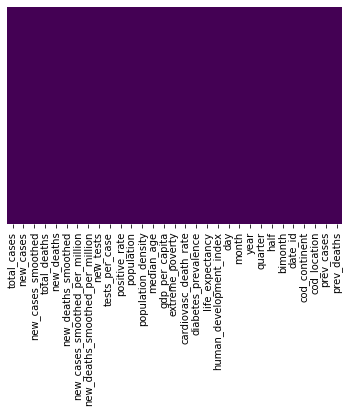

In [7]:
sea.heatmap(coronga.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [8]:
#Saida em .csv
coronga.to_csv('in.csv')

In [9]:
coronga.to_csv('dataset.csv', sep=';', decimal=',')